## Business Understanding

**StakeHolder**: A **novice investor** who is following financial news on twitter


In [13]:
# Importing all important packages for modeling
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
set_config(display='diagram')
stop_words = stopwords.words('english')
stop_words.append('https')

### Preprocessing the Text Data

In [2]:
# Creating a class that allows text to be preprocessed 
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        # define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        
        # this is where you would fit corpus specific stopwords
        # fit probable bigrams with bigram model in here
        # save as parameters of Text preprocessor
        return self
    
    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        
        return normalized_corpus
        
    def process_doc(self, doc):
        
        # Initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
        
        
        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]
        
        # POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
        
        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [3]:
# Uploading the necessary train and test data
# The data I used was already split into test and train
train= pd.read_csv('sent_train.csv')
test = pd.read_csv('sent_valid.csv')
X_train = train['text']
X_test = test['text']
y_train = train['label']
y_test = test['label']

In [4]:
# Instantiating the textpreprocessor and fitting/ transforming my X_train
processor = TextPreprocessor()
X_train_transformed = processor.fit_transform(X_train)

In [5]:
# Converting X_train to dataframe so it can be fit in the pipeline
X_train_frame = X_train_transformed.to_frame()

### First Simple Model (FSM) - Complement Naive Bayes

In [49]:
# Creating a pipeline for my model using the complement Naive Bayes because there is a class imbalance
Tweet_text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

preprocessor = ColumnTransformer(transformers = [
    ('tweet_text', Tweet_text_transformer, ['text'])])

steps = [('preprocessor', preprocessor), ('ros', RandomOverSampler(random_state = 24, sampling_strategy = 'not majority')), 
         ('compNB', ComplementNB())]

model_pipe = Pipeline(steps)

In [50]:
# fitting the model
model_pipe.fit(X_train_frame, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D131630C10>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D10E254940>))]),
                                                  ['text'])])),
                ('ros',
                 RandomOverSampler(random_state=24,
                                   sampling_strategy='not majority')),
                ('compNB', ComplementNB())])

In [58]:
# Finding the model train score
model_pipe.score(X_train_frame, y_train)

0.8651367494498585

In [48]:
#Finding the model test score
X_test_transformed = processor.transform(X_test)
X_test_toframe = X_test_transformed.to_frame()
y_pred = model_pipe.predict(X_test_toframe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.71      0.56       347
           1       0.57      0.68      0.62       475
           2       0.90      0.74      0.81      1566

    accuracy                           0.72      2388
   macro avg       0.64      0.71      0.66      2388
weighted avg       0.77      0.72      0.74      2388



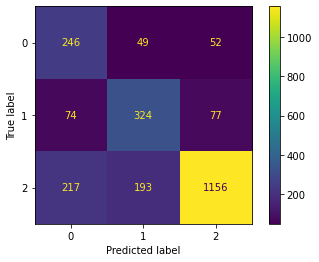

In [11]:
# Plotting a confusion matrix to display the accuracy of my model on the test data
plot_confusion_matrix(model_pipe, X_test_toframe,
                      y_test);

**Based on the models train score and the models test score it seems to be over fitting a little bit. In my next model I am going to hyper parameter tune to see if that helps regularization.**

### Hyper Parameter Tuning the FSM

In [34]:
# Grid searching on the given paramters and instantiating GridSearchCV
gridparams =  [{'compNB__alpha' : [1, .8, .85, .9, .95],
         'ros__sampling_strategy': ['not majority'],
               'preprocessor__tweet_text__vec__max_df': [.95, .8, .7, .6],
               'preprocessor__tweet_text__vec__min_df': [0, .05, .1, .2],
               'preprocessor__tweet_text__vec__ngram_range': [(1,1),(1,2)]}
       ]
GridSearch = GridSearchCV(model_pipe, param_grid = gridparams, scoring= 'f1_weighted', cv = 3)

In [36]:
# Fitting the model to the training data 
GridSearch.fit(X_train_frame, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tweet_text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D135B3BD30>)),
                                                                                         ('vec',
                                                                                          CountVectorizer()),
                                                                                         ('array',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D135B3BC10>))]),
                                                                         ['text'])])),
                                       ('ros',
                                        RandomOverSampler(random_sta...
                                                          sampling_strategy='not '
                                                                            'majority')),
                                       ('compNB', ComplementNB())]),
             param_grid=[{'compNB__alpha': [1, 0.8, 0.85, 0.9, 0.95],
                          'preprocessor__tweet_text__vec__max_df': [0.95, 0.8,
                                                                    0.7, 0.6],
                          'preprocessor__tweet_text__vec__min_df': [0, 0.05,
                                                                    0.1, 0.2],
                          'preprocessor__tweet_text__vec__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                          'ros__sampling_strategy': ['not majority']}],
             scoring='f1_weighted')

In [59]:
# The model performed extremely well on the train data
best_model_ComplementNB = GridSearch.best_estimator_
best_model_ComplementNB.score(X_train_frame, y_train)

0.9658388347479828

In [60]:
# However the model did not perform well on the test data
best_model_ComplementNB_pred = best_model_ComplementNB.predict(X_test_toframe)
print(classification_report(y_test, best_model_ComplementNB_pred))

              precision    recall  f1-score   support

           0       0.50      0.70      0.59       347
           1       0.61      0.73      0.66       475
           2       0.90      0.77      0.83      1566

    accuracy                           0.75      2388
   macro avg       0.67      0.73      0.69      2388
weighted avg       0.79      0.75      0.76      2388



**Hyper Paramter tuning the complement Naive Bayes model just made it extremely more overfit. Going to switch over to a different classifier to make it easier to regularize.**

### Random Forest Model

In [19]:
# Using the same pipeline as before by using a Random Forest Classifier
Tweet_text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

preprocessor = ColumnTransformer(transformers = [
    ('tweet_text', Tweet_text_transformer, ['text'])])

steps = [('preprocessor', preprocessor), ('ros', RandomOverSampler(random_state = 24, sampling_strategy = 'not majority')), 
         ('rf', RandomForestClassifier(random_state = 24, max_depth = 4))]

rfmodel_pipe = Pipeline(steps)

In [20]:
# Fitting the model on the train data
rfmodel_pipe.fit(X_train_frame, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D173F903A0>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D173F90430>))]),
                                                  ['text'])])),
                ('ros',
                 RandomOverSampler(random_state=24,
                                   sampling_strategy='not majority')),
                ('rf', RandomForestClassifier(max_depth=4, random_state=24))])

In [21]:
# Model Train score
rfmodel_pipe.score(X_train_frame, y_train)

0.7476684480771246

In [23]:
# Model test score
rf_y_pred = rfmodel_pipe.predict(X_test_toframe)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53       347
           1       0.60      0.58      0.59       475
           2       0.84      0.82      0.83      1566

    accuracy                           0.74      2388
   macro avg       0.65      0.66      0.65      2388
weighted avg       0.74      0.74      0.74      2388



**The train and test scores were similar for the Random Forest model. Aiming to get a better score so I am going to hyper parameter tune the model.**

### Hyper Parameter tuning the RandomForest Model

In [55]:
# Hyper parameter tuning parameters
rfgridparams =  [{'rf__max_depth' : [3, 4, 5, 6, 7],
                  'rf__n_estimators' : [50, 100, 150, 200],
                  'rf__min_samples_split': [2,5, 6, 8, 10],
                'rf__min_samples_leaf': [3,4,5,6, 10, 15],
         'ros__sampling_strategy': ['not majority'],
               'preprocessor__tweet_text__vec__max_df': [.95, .9],
               'preprocessor__tweet_text__vec__min_df': [.05, .1, .2],
               'preprocessor__tweet_text__vec__ngram_range': [(1,1),(1,2)]}]

In [56]:
# Fitting the model to GridSearchCv
RFGridSearch = GridSearchCV(rfmodel_pipe, param_grid = rfgridparams, scoring= 'f1_weighted', cv = 4)

In [57]:
RFGridSearch.fit(X_train_frame, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tweet_text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D173F903A0>)),
                                                                                         ('vec',
                                                                                          CountVectorizer()),
                                                                                         ('array',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D173F90430>))]),
                                                                         ['text'])])),
                                       ('ros',
                                        RandomOverSampler(random_sta...
             param_grid=[{'preprocessor__tweet_text__vec__max_df': [0.95, 0.9],
                          'preprocessor__tweet_text__vec__min_df': [0.05, 0.1,
                                                                    0.2],
                          'preprocessor__tweet_text__vec__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                          'rf__max_depth': [3, 4, 5, 6, 7],
                          'rf__min_samples_leaf': [3, 4, 5, 6, 10, 15],
                          'rf__min_samples_split': [2, 5, 6, 8, 10],
                          'rf__n_estimators': [50, 100, 150, 200],
                          'ros__sampling_strategy': ['not majority']}],
             scoring='f1_weighted')